<a href="https://colab.research.google.com/github/alaa7amid/Ecommerce/blob/main/tomato_leaf_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tomato Leaf Disease


# importing Libraries

In [ ]:
# Download the dataset from Kaggle

! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggl
e
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat '/content/kaggle.json': No such file or directory


NameError: ignored

In [ ]:
! kaggle datasets download -d ammarnassanalhajali/tomato-diseases-dataset-csvimages

100% 276M/277M [00:11<00:00, 29.1MB/s]
100% 277M/277M [00:11<00:00, 24.8MB/s]


In [ ]:
! unzip -q /content/tomato-diseases-dataset-csvimages.zip

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, cv2, json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.applications import ResNet50

from tensorflow.keras.optimizers import Adam

from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D

# Loading Data

In [ ]:
data= pd.read_csv("/content/train.csv")

NameError: ignored

In [ ]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
data.drop('path', axis=1, inplace=True)

## Data processing

In [ ]:

data['img'] = data['img'].apply(lambda x: "/content/Tomato_images/Tomato_images/" + x)

In [ ]:
data

,img,label_text,label
0,/content/Tomato_images/Tomato_images/781e93a9-...,Tomato___Late_blight,2
1,/content/Tomato_images/Tomato_images/283ff0be-...,Tomato___Late_blight,2
2,/content/Tomato_images/Tomato_images/0db85707-...,Tomato___Late_blight,2
3,/content/Tomato_images/Tomato_images/078a999d-...,Tomato___Late_blight,2
4,/content/Tomato_images/Tomato_images/3dcee9ed-...,Tomato___Late_blight,2
...,...,...,...
18155,/content/Tomato_images/Tomato_images/0e20026b-...,Tomato___Spider_mites Two-spotted_spider_mite,5
18156,/content/Tomato_images/Tomato_images/85247ca8-...,Tomato___Spider_mites Two-spotted_spider_mite,5
18157,/content/Tomato_images/Tomato_images/6f12dc84-...,Tomato___Spider_mites Two-spotted_spider_mite,5
18158,/content/Tomato_images/Tomato_images/c71a53bd-...,Tomato___Spider_mites Two-spotted_spider_mite,5


In [ ]:
data.isnull().sum()

img           0
label_text    0
label         0
dtype: int64

In [ ]:
data.label.value_counts() #The number of data per label

7    5357
0    2127
2    1909
4    1771
5    1676
9    1591
6    1404
1    1000
3     952
8     373
Name: label, dtype: int64

In [ ]:
grouped = data[['label', 'label_text']].groupby(data.label)
for value, group_data in grouped:
    print(f"Unique Value: {value}")
    print(group_data)
    print("=" * 20)


Unique Value: 0
       label               label_text
11628      0  Tomato___Bacterial_spot
11629      0  Tomato___Bacterial_spot
11630      0  Tomato___Bacterial_spot
11631      0  Tomato___Bacterial_spot
11632      0  Tomato___Bacterial_spot
...      ...                      ...
13750      0  Tomato___Bacterial_spot
13751      0  Tomato___Bacterial_spot
13752      0  Tomato___Bacterial_spot
13753      0  Tomato___Bacterial_spot
13754      0  Tomato___Bacterial_spot

[2127 rows x 2 columns]
Unique Value: 1
      label             label_text
3500      1  Tomato___Early_blight
3501      1  Tomato___Early_blight
3502      1  Tomato___Early_blight
3503      1  Tomato___Early_blight
3504      1  Tomato___Early_blight
...     ...                    ...
4495      1  Tomato___Early_blight
4496      1  Tomato___Early_blight
4497      1  Tomato___Early_blight
4498      1  Tomato___Early_blight
4499      1  Tomato___Early_blight

[1000 rows x 2 columns]
Unique Value: 2
      label            lab

# Splitting DataSet

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_validate, y_train, y_test = train_test_split(data, data.label,
                                                    train_size=0.8,
                                                    random_state=42,
                                                    stratify=data.label)

In [ ]:
df_train = df_train.reset_index(drop=True)
df_validate = df_validate.reset_index(drop=True)

# Visualizing Data

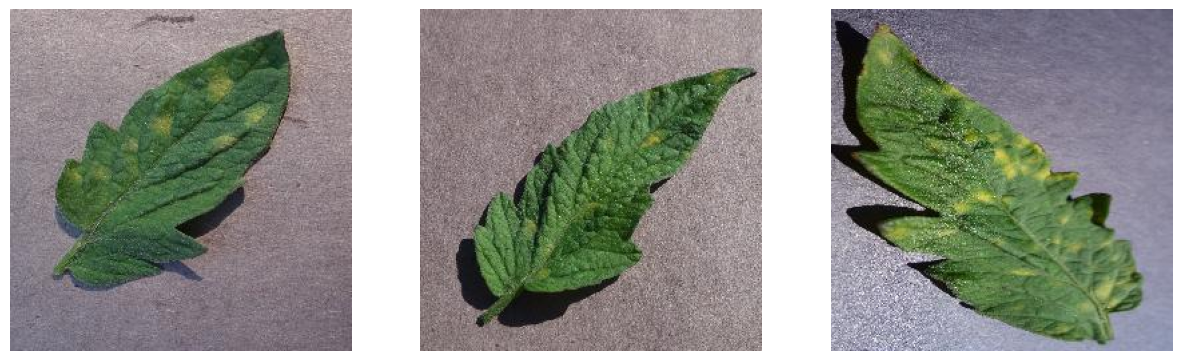

In [ ]:
sample = df_train[df_train.label == 3].sample(3)
plt.figure(figsize=(15, 5))
for ind, (img, label) in enumerate(zip(sample.img, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join("/content/Tomato_images/Tomato_images", img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")

plt.show()

# Parameters

In [ ]:
# Main parameters
BATCH_SIZE = 16
STEPS_PER_EPOCH = len(data)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(data)*0.2 / BATCH_SIZE
EPOCHS =12 #
IMG_WIDTH= 256
IMG_HEIGHT= 256
train_dir = "/content/drive/MyDrive/tomato/Tomato_images/Tomato_images"

In [ ]:
df_train.label = df_train.label.astype('str')
df_validate.label = df_validate.label.astype('str')

# Data Generator

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               rotation_range = 180,
                               vertical_flip = True,
                               horizontal_flip = True)
# our train_datagen generator will use the following transformations on the images
validation_datagen = ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_dataframe(df_train,
                                                    train_dir,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    x_col='img',
                                                    y_col='label',
                                                    class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_dataframe(df_validate,
                                                   train_dir,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    x_col='img',
                                                    y_col='label',
                                                    class_mode='categorical',
                                                  batch_size=BATCH_SIZE)

Found 14528 validated image filenames belonging to 10 classes.
Found 3632 validated image filenames belonging to 10 classes.


# Creating Model

In [ ]:
def create_model():
    efficientnet_layers = InceptionV3(weights='imagenet',
                                         include_top=False,
                                         input_shape = (IMG_WIDTH, IMG_HEIGHT, 3),
                                         pooling='avg')

    model = Sequential()
    model.add(efficientnet_layers)
    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "categorical_crossentropy",
                  metrics = ["acc"])

    return model


In [ ]:
model = create_model()
model.summary()

87910968/87910968 [==============================] - 4s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 21,823,274
Trainable params: 21,788,842
Non-trainable params: 34,432
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 21,823,274
Trainable params: 21,788,842
Non-trainable params: 34,432
_________________________________________________________________


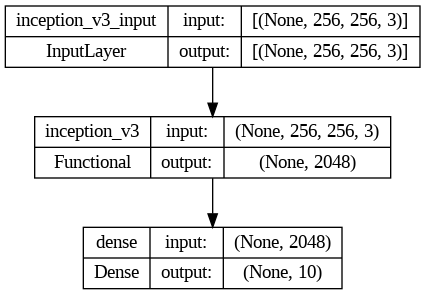

In [ ]:
from keras.utils import plot_model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file='naive_inception_module.png')

# Training

In [ ]:

model_save = ModelCheckpoint('./InceptionV3_256.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss',
                             mode = 'min', verbose = 1)

early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001,
                           patience = 10, mode = 'min', verbose = 1,
                           restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3,
                              patience = 2, min_delta = 0.001,
                              mode = 'min', verbose = 1)


history = model.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save, early_stop, reduce_lr]
)

Epoch 1/12
908/908 [==============================] - ETA: 0s - loss: 0.5706 - acc: 0.8129
Epoch 1: val_loss improved from inf to 1.54750, saving model to ./InceptionV3_256.h5
908/908 [==============================] - 361s 337ms/step - loss: 0.5706 - acc: 0.8129 - val_loss: 1.5475 - val_acc: 0.6162 - lr: 0.0010
Epoch 2/12
908/908 [==============================] - ETA: 0s - loss: 0.2751 - acc: 0.9087
Epoch 2: val_loss improved from 1.54750 to 1.12483, saving model to ./InceptionV3_256.h5
908/908 [==============================] - 317s 349ms/step - loss: 0.2751 - acc: 0.9087 - val_loss: 1.1248 - val_acc: 0.7117 - lr: 0.0010
Epoch 3/12
908/908 [==============================] - ETA: 0s - loss: 0.2440 - acc: 0.9193
Epoch 3: val_loss improved from 1.12483 to 0.36929, saving model to ./InceptionV3_256.h5
908/908 [==============================] - 301s 331ms/step - loss: 0.2440 - acc: 0.9193 - val_loss: 0.3693 - val_acc: 0.8711 - lr: 0.0010
Epoch 4/12
908/908 [==============================

# Visualizing Results

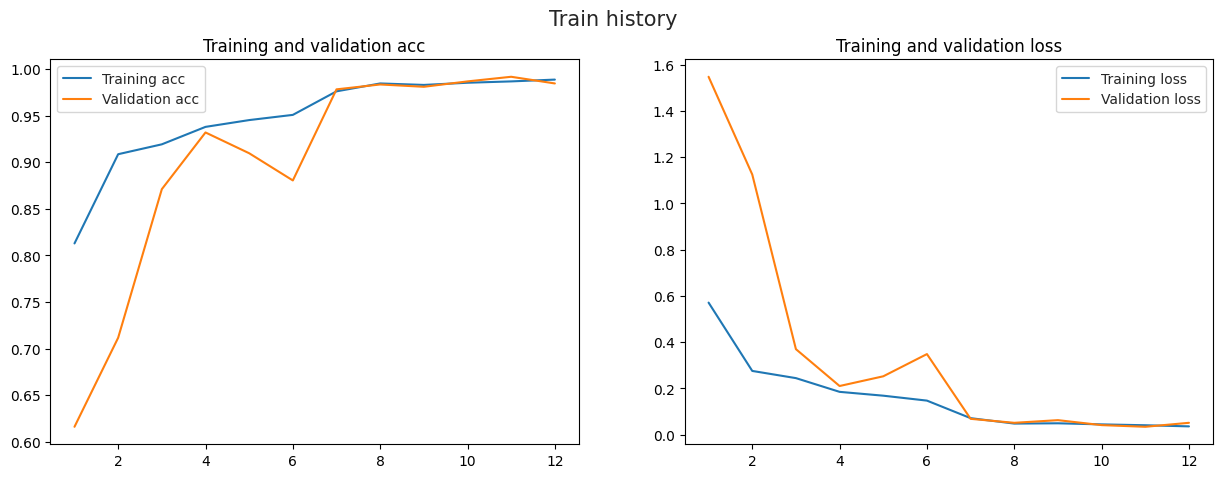

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, label = "Training acc")
ax1.plot(epochs, val_acc,  label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss,  label = "Training loss")
ax2.plot(epochs, val_loss, label = "Validation loss")
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

In [ ]:
'''Tomato_mosaic_virus
Target_Spot
Bacterial_spot
Tomato_Yellow_Leaf_Curl_Virus
Late_blight
Leaf_Mold
Early_blight
Spider_mites Two-spotted_spider_mite
Tomato___healthy
Septoria_leaf_spot'''

'Tomato_mosaic_virus\nTarget_Spot\nBacterial_spot\nTomato_Yellow_Leaf_Curl_Virus\nLate_blight\nLeaf_Mold\nEarly_blight\nSpider_mites Two-spotted_spider_mite\nTomato___healthy\nSeptoria_leaf_spot'

In [ ]:
data.label_text.unique()

array(['Tomato___Late_blight', 'Tomato___healthy',
       'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot',
       'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
       'Tomato___Bacterial_spot', 'Tomato___Target_Spot',
       'Tomato___Tomato_mosaic_virus', 'Tomato___Leaf_Mold',
       'Tomato___Spider_mites Two-spotted_spider_mite'], dtype=object)

In [ ]:
data.label.unique()

array([2, 9, 1, 4, 7, 0, 6, 8, 3, 5])

In [ ]:
data.label.value_counts()

7    5357
0    2127
2    1909
4    1771
5    1676
9    1591
6    1404
1    1000
3     952
8     373
Name: label, dtype: int64

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install gradio -q

In [ ]:
import gradio as gr
import os
import cv2
import numpy as np
import matplotlib.pyplot as mati
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image


# Load the model
model = load_model('/content/drive/MyDrive/InceptionV3_256.h5')
# Example class labels
class_labels = {
    0: "Tomato___Bacterial_spot",
    1: "Tomato___Early_blight",
    2: "Tomato___Late_blight",
    3: "Tomato___Leaf_Mold",
    4:"Tomato___Septoria_leaf_spot",
    5: "Tomato___Spider_mites Two-spotted_spider_mite",
    6: "Tomato___Target_Spot",
    7: "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
    8: "Tomato___Tomato_mosaic_virus",
    9: "Tomato___healthy"
}
def preprocess_image(img, target_size):
    img_resized = np.resize(img, target_size)
    img_array = img_resized.astype(np.float32) / 255.0
    img_expanded = np.expand_dims(img_array, axis=0)
    return img_expanded

def classify_image(img):
    target_size = (256, 256, 3)  # Set your target image size
    img_preprocessed = preprocess_image(img, target_size)
    predictions = model.predict(img_preprocessed)
    class_indexes = np.argsort(predictions)
    predicted_labels = {class_labels.get(class_index): float(predictions[0][class_index]) for class_index in class_indexes[0]}
    return predicted_labels

In [ ]:
# Define the input interface (upload an image)
iface = gr.Interface(
    fn=classify_image,
    inputs="image",
    outputs="label",
    title="Tomato Classification",
    live=True,
    description="Upload an image of a tomato and the model will predict its class."
)

# Launch the interface
iface.launch(debug=True, share=True, )

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://fc674a10f9121c0a24.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 10s 10s/step
